In [1]:
#load csv and plot it
from numpy import genfromtxt
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

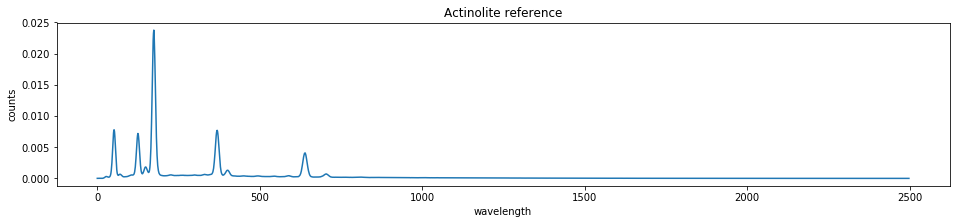

total of 12069532 samples


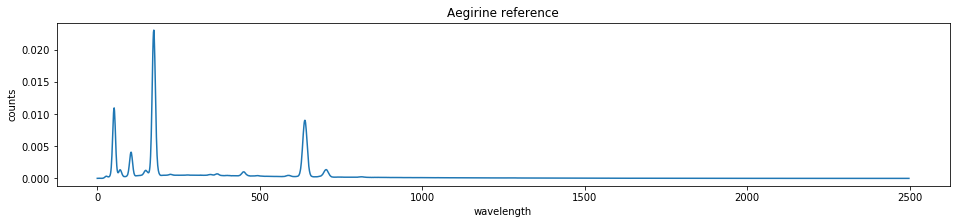

total of 11987585 samples


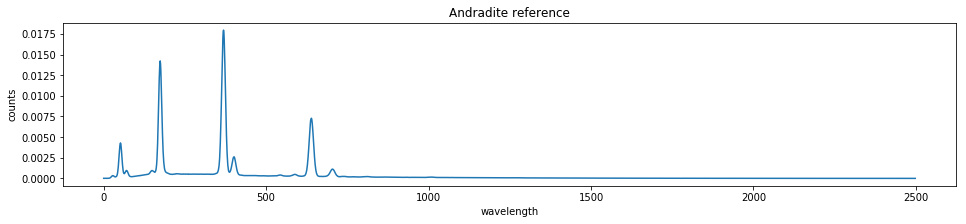

total of 13253202 samples


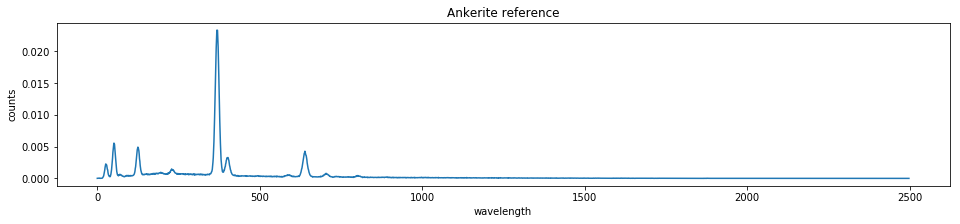

total of 413566 samples


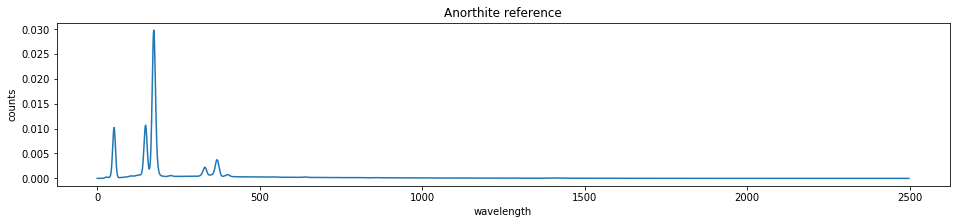

total of 11625458 samples


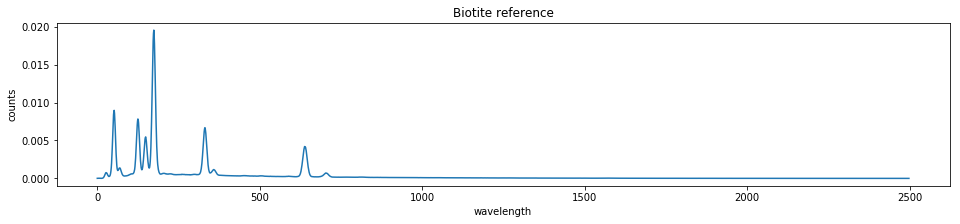

total of 12759798 samples


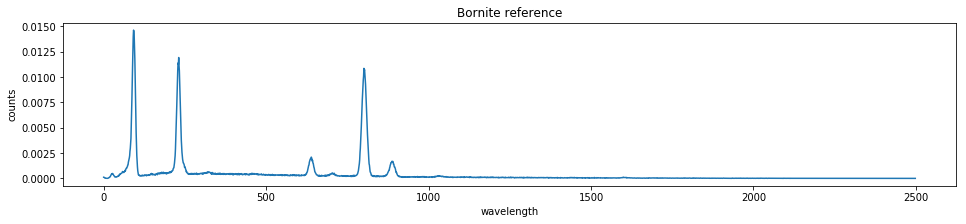

total of 396518 samples


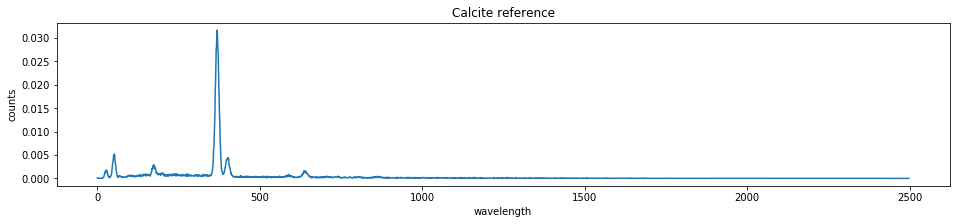

total of 53480 samples


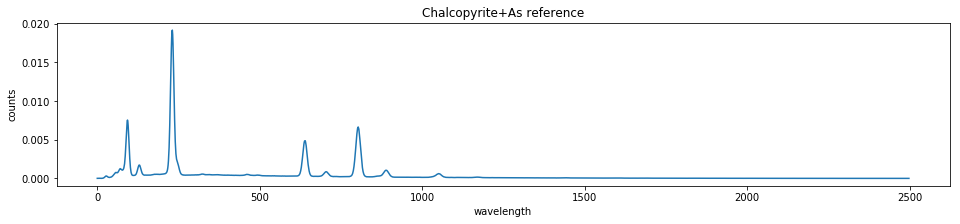

total of 15904153 samples


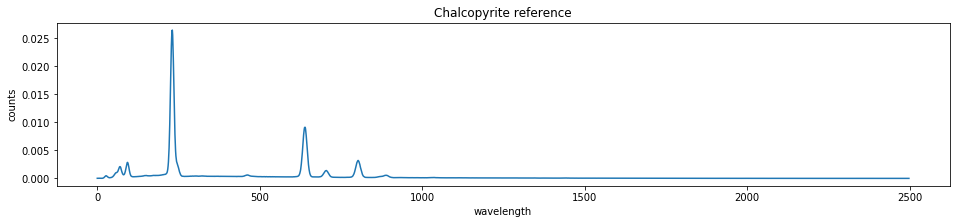

total of 7968245 samples


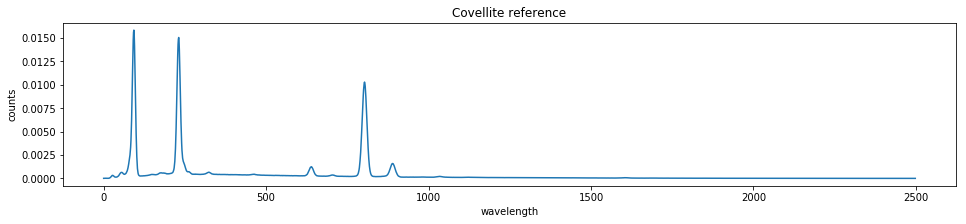

total of 16666790 samples


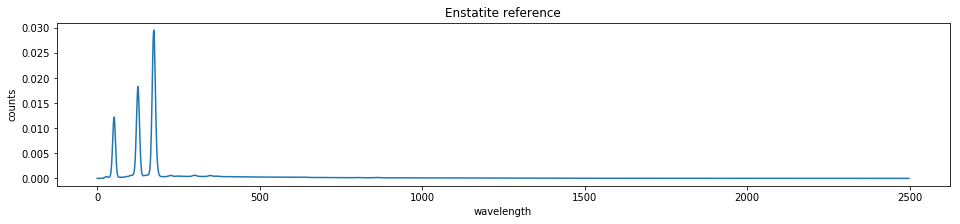

total of 11446766 samples


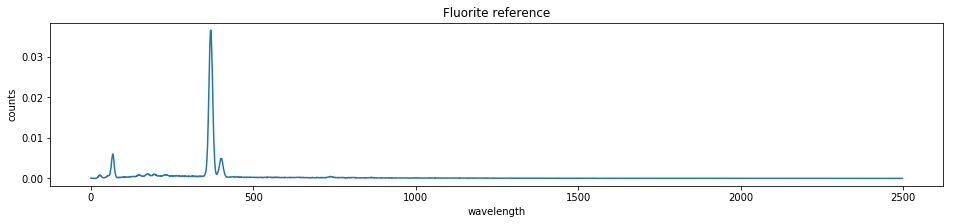

total of 234632 samples


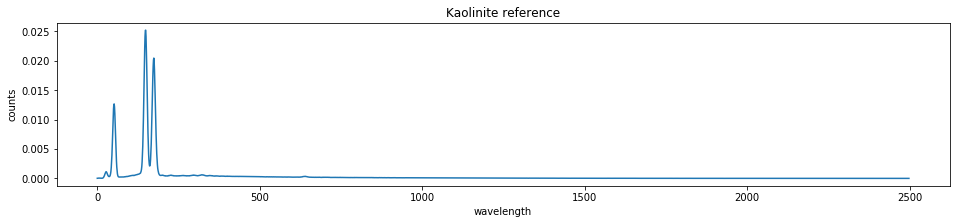

total of 4683439 samples


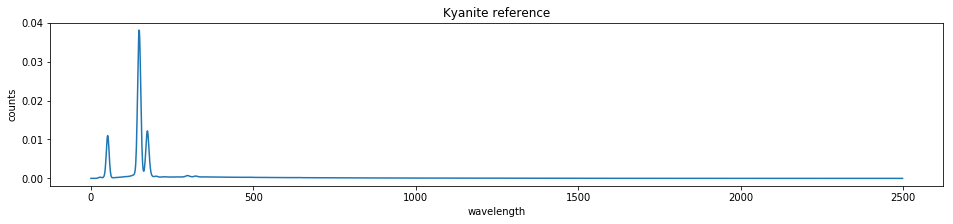

total of 12199963 samples


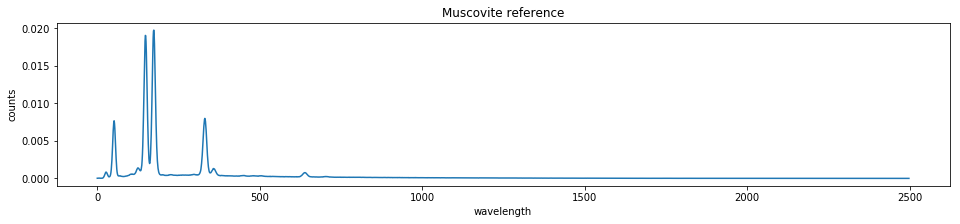

total of 5839409 samples


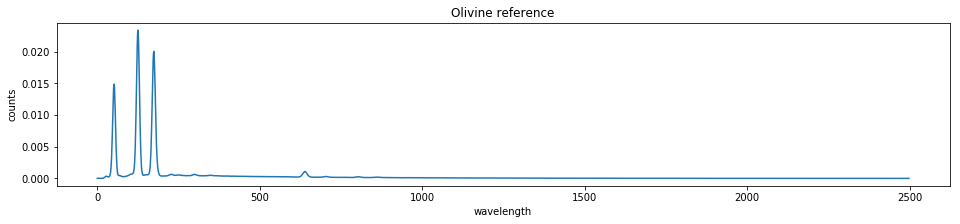

total of 11166537 samples


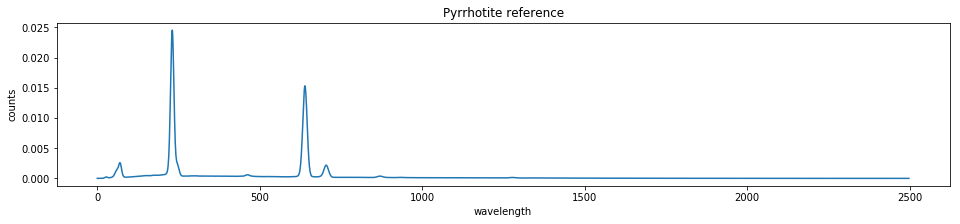

total of 16418760 samples


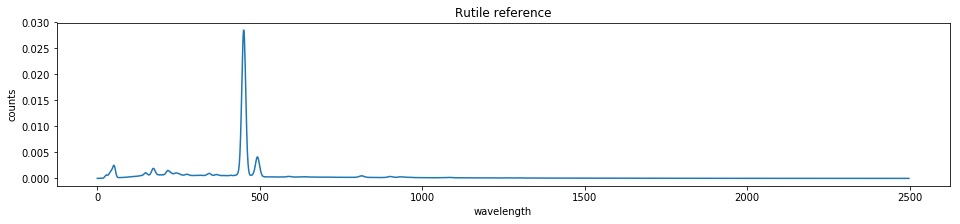

total of 7294622 samples


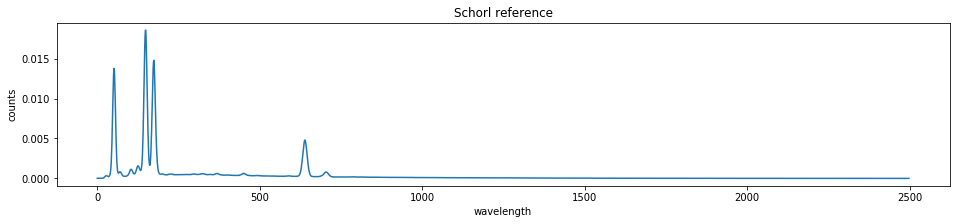

total of 11128828 samples


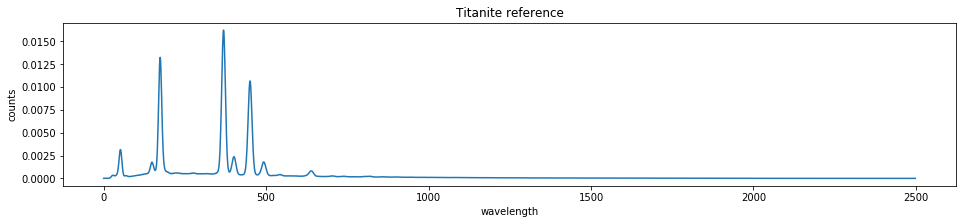

total of 13110533 samples


In [2]:
materials = ['Actinolite','Aegirine','Andradite','Ankerite','Anorthite','Biotite','Bornite','Calcite','Chalcopyrite+As','Chalcopyrite','Covellite','Enstatite','Fluorite','Kaolinite','Kyanite','Muscovite','Olivine','Pyrrhotite','Rutile','Schorl','Titanite']#,'Hematite','Monazite','Orthoclase','Quartz','Sphalerite','Zircon',]

for material in materials:
    b = genfromtxt('reference/'+material+'.csv', delimiter=',')

    h_size = len(b)

    plt.figure(figsize=(16, 3))
    plt.plot(b/np.sum(b))
    plt.ylabel('counts')
    plt.xlabel('wavelength')
    plt.title(material+' reference')
    plt.show()

    print('total of '+ str(int(np.sum(b))) + ' samples')

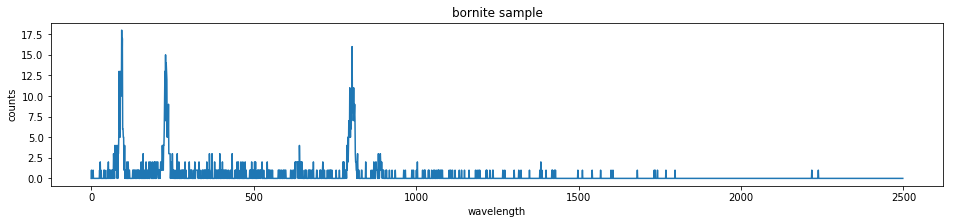

total of 1000 samples


In [3]:
sample = genfromtxt('noisy - 1000 events/bornite-1.csv', delimiter=',')
plt.figure(figsize=(16, 3))

plt.plot(sample)
plt.ylabel('counts')
plt.xlabel('wavelength')
plt.title('bornite sample')
plt.show()

print('total of '+ str(int(np.sum(sample))) + ' samples')

In [4]:
#re-purposed code from https://github.com/ucsbdeepspace/cofe-python-analysis-tools/blob/master/utils_meinhold/cofe_util.py
import scipy
def rebin_factor( a, newshape ):
        '''Rebin an array to a new shape.
        newshape must be a factor of a.shape.
        '''
        assert len(a.shape) == len(newshape)
        assert not scipy.sometrue(scipy.mod( a.shape, newshape ))

        slices = [ slice(None,None, old/new) for old,new in zip(a.shape,newshape) ]
        return a[slices]

In [5]:
#prepare gaussian for smoothing
N=100
sigma=5

#try smoothing with a gaussian:
dx = float(3940-3930)/N
gx = np.arange(-3*sigma, 3*sigma, dx)
gaussian = np.exp(-(gx/sigma)**2/2)
print(np.shape(gaussian))

(300,)


In [6]:
n_bins=h_size #a factor of h_size

sample_names = ['bornite-1','bornite-2','bornite-3','bornite-4','bornite-5','chalcopyrite-1','chalcopyrite-2','chalcopyrite-3','chalcopyrite-4','chalcopyrite-5','covellite-1','covellite-2','covellite-3','covellite-4','covellite-5','pyrite-1','pyrite-2','pyrite-3','pyrite-4','pyrite-5']
samples = np.zeros([len(sample_names),n_bins])
raw_samples = []
for n, material in enumerate(sample_names):
    sample = genfromtxt('noisy - 1000 events/'+material+'.csv', delimiter=',')
    
    #raw samples are individual measurements
    raw_sample = np.zeros(0)
    indexes=np.nonzero(sample)
    for i in np.transpose(indexes):
        for m in range(0,sample[i]):
            raw_sample = np.append(raw_sample,np.array(i))
    raw_samples.append(raw_sample)
    
    samples[n,:]=rebin_factor(sample,[n_bins])

print('loaded '+str(len(sample_names))+' sample histograms')

materials = ['Actinolite','Aegirine','Andradite','Ankerite','Anorthite','Biotite','Bornite','Calcite','Chalcopyrite+As','Chalcopyrite','Covellite','Enstatite','Fluorite','Kaolinite','Kyanite','Muscovite','Olivine','Pyrrhotite','Rutile','Schorl','Titanite']#,'Hematite','Monazite','Orthoclase','Quartz','Sphalerite','Zircon',]

#read in all references which are 2500 long and all samples
references = np.zeros([len(materials)+1,n_bins])

for n, material in enumerate(materials):
    sample = genfromtxt('reference/'+material+'.csv', delimiter=',')
    references[n,:]=rebin_factor(sample,[n_bins])
    
materials.append('Pyrite')
pyrite_ref, _ = np.histogram(np.concatenate(raw_samples[15:19]),h_size,range=(0,h_size))
pyrite_ref = np.array(pyrite_ref, np.int32)
pyrite_ref = pyrite_ref.astype(float)
references[-1,:] = pyrite_ref

#smooth the references by gaussian
for n, material in enumerate(materials):
    references[n,:] = np.convolve(references[n,:], gaussian, mode="same")

print('loaded '+str(len(materials))+' reference histograms')

labels=[6,6,6,6,6,9,9,9,9,9,10,10,10,10,10,21,21,21,21,21]

loaded 20 sample histograms
loaded 22 reference histograms


In [13]:
#for each sample, classify it with a random subset of events samples (events<1000)
accuracy=np.zeros(0)
for e, events in enumerate(range(1,970,10)):
    outcomes=[]
    for experiments in range(0,100):
        for sample_n, sample in enumerate(samples):        
            local_sample,_ = np.histogram(np.random.choice(raw_samples[sample_n], events, replace=False),h_size,range=(0,h_size))
            local_sample = np.array(local_sample, np.int32)
            local_sample = local_sample.astype(float)
            
            #smooth the histogram
            local_sample = np.convolve(local_sample, gaussian, mode="same")

            #strategy 1: nearest reference in compensated hyperspace
            normalized_sample = local_sample / np.sum(local_sample)
            normalized_references = references / np.sum(references,1)[:,None]

            distances = np.sqrt(np.sum(np.power(normalized_references-normalized_sample[None,:],2),1))
            #print(np.argsort(distances))
            nearest = np.argmin(distances)

            #print('according to strategy 1, sample '+sample_names[sample_n]+' is '+materials[nearest])
            if labels[sample_n]==nearest:
                outcomes=np.append(outcomes,1)
            else:
                outcomes=np.append(outcomes,0)

    print('for '+str(events)+' photons, accuracy: '+str(np.sum(outcomes)/np.size(outcomes)))
    accuracy=np.append(accuracy,np.sum(outcomes)/np.size(outcomes))

for 1 photons, accuracy: 0.2445
for 11 photons, accuracy: 0.512
for 21 photons, accuracy: 0.6175
for 31 photons, accuracy: 0.678
for 41 photons, accuracy: 0.7205
for 51 photons, accuracy: 0.744
for 61 photons, accuracy: 0.7525
for 71 photons, accuracy: 0.7935
for 81 photons, accuracy: 0.805
for 91 photons, accuracy: 0.8185
for 101 photons, accuracy: 0.8235
for 111 photons, accuracy: 0.8325
for 121 photons, accuracy: 0.8455
for 131 photons, accuracy: 0.8445
for 141 photons, accuracy: 0.8535
for 151 photons, accuracy: 0.8585
for 161 photons, accuracy: 0.8755
for 171 photons, accuracy: 0.8885
for 181 photons, accuracy: 0.8745
for 191 photons, accuracy: 0.8875
for 201 photons, accuracy: 0.883
for 211 photons, accuracy: 0.901
for 221 photons, accuracy: 0.899
for 231 photons, accuracy: 0.898
for 241 photons, accuracy: 0.891
for 251 photons, accuracy: 0.904
for 261 photons, accuracy: 0.917
for 271 photons, accuracy: 0.9115
for 281 photons, accuracy: 0.9105
for 291 photons, accuracy: 0.916
for

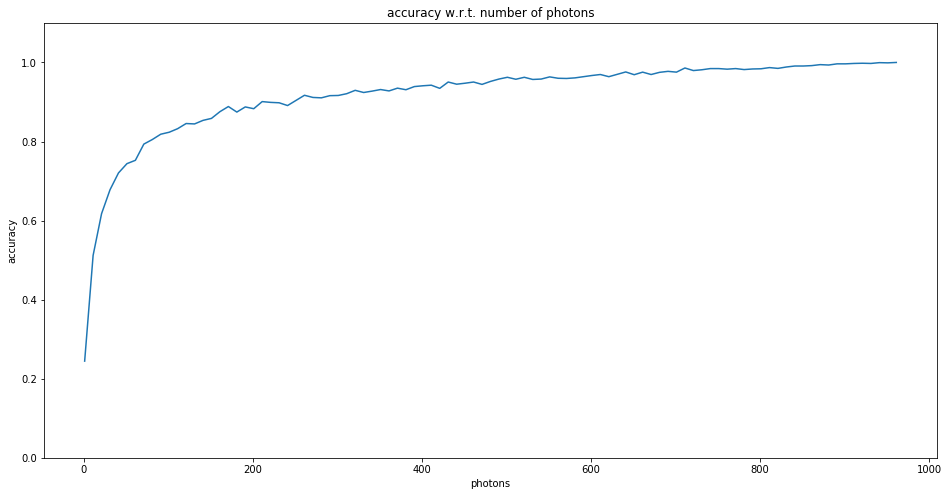

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(range(1,970,10),accuracy)
axes = plt.gca()
axes.set_ylim([0,1.1])
plt.ylabel('accuracy')
plt.xlabel('photons')
plt.title('accuracy w.r.t. number of photons')
plt.show()